# Preliminaries

In [1]:
import numpy as np
import scipy.linalg
import scipy.io.arff
import matplotlib.pyplot as plt
import time
import math
import os

In [2]:
inv = np.linalg.inv
norm = np.linalg.norm
sqrtm = scipy.linalg.sqrtm

# Load data

In [3]:
dataset = 'synthetic'
# dataset = 'mediamill'

In [4]:
X = np.load(f"data/{dataset}/view1.npy")
Y = np.load(f"data/{dataset}/view2.npy")

### Dataset dimensions

In [5]:
x_dim = X.shape[0]; y_dim = Y.shape[0]; samples = X.shape[1]

### Compute correlation matrix

In [6]:
Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

Rxy = inv(sqrtm(Cxx))@Cxy@inv(sqrtm(Cyy))

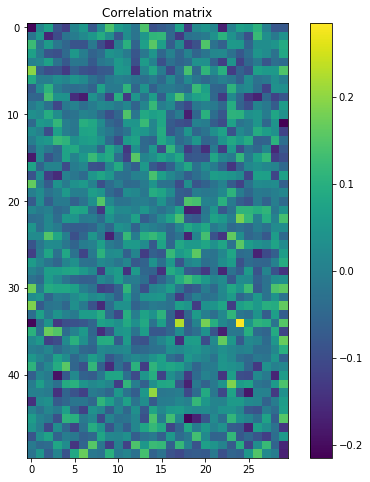

In [7]:
fig = plt.figure(figsize=(8,8))

plt.imshow(Rxy)
plt.title('Correlation matrix')
plt.colorbar()
plt.show()

### Plot canonical correlations

In [8]:
u, s, vh = np.linalg.svd(Rxy)

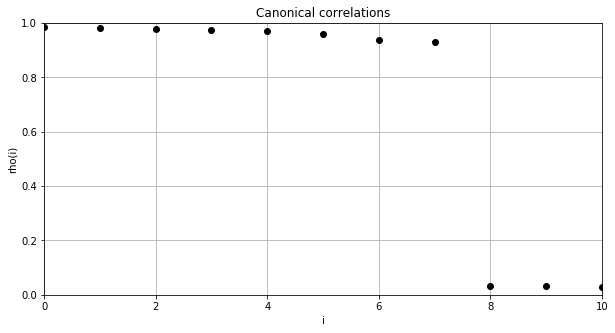

In [9]:
fig = plt.figure(figsize=(10,5))

plt.plot(s, 'o', color='black')
plt.xlim(0,10)
plt.ylim(0,1)
plt.title('Canonical correlations')
plt.xlabel('i')
plt.ylabel('rho(i)')
plt.grid()
plt.show()

### Offline solution

In [10]:
Ux = u[:,:10]
Uy = vh.T[:,:10]

# Adaptive Bio-CCA with output whitening

### Parameters

In [15]:
trials = 1; epochs = 5; iters = samples*epochs; alpha = 1.5; z_dim = 10; n_dim = z_dim;

### Hyperparameter search

In [16]:
logeta0_list = [-3]; logdecay_list = [-4]; tau_list = [1]

### Subsample points to plot on log scale

In [17]:
approx_n_points = 1000
domain = list(sorted(set(map(int, np.round(np.logspace(0, np.log(iters-1), base=np.e, num=approx_n_points))))))
domain_len = len(domain)

### Online algorithm

eta0=0.001 decay=0.0001 tau=1
Trial 1:
Epoch 1:
run time: 4.753127813339233 seconds


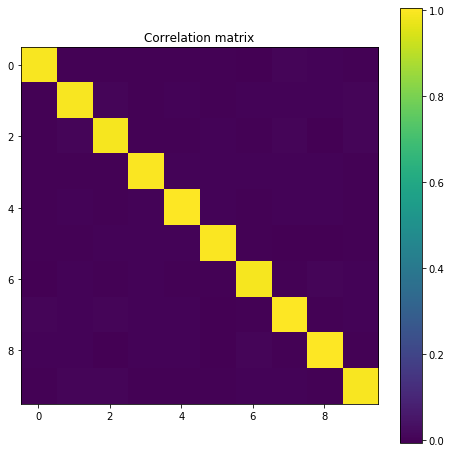

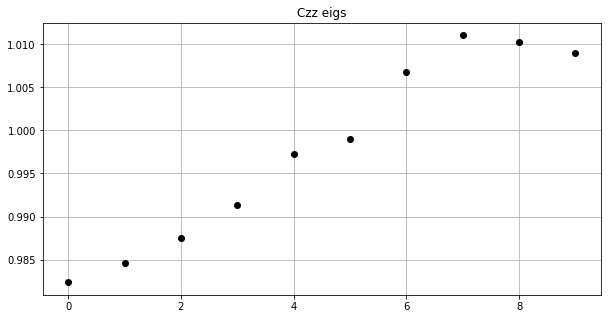

Epoch 2:
run time: 9.734103918075562 seconds


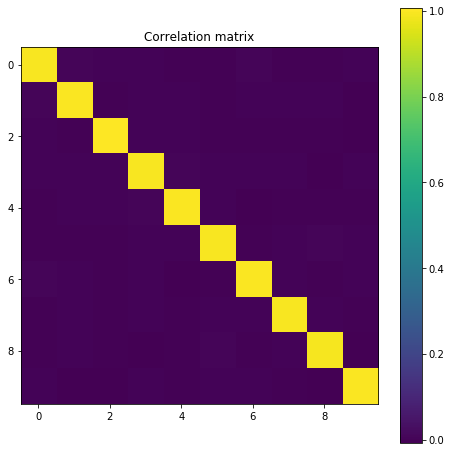

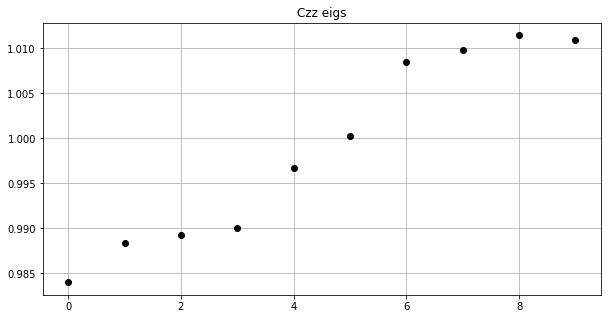

Epoch 3:
run time: 15.115359783172607 seconds


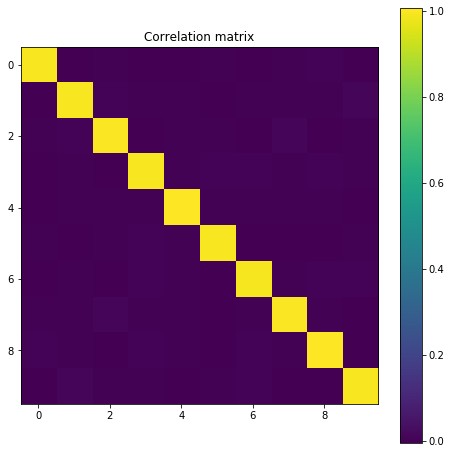

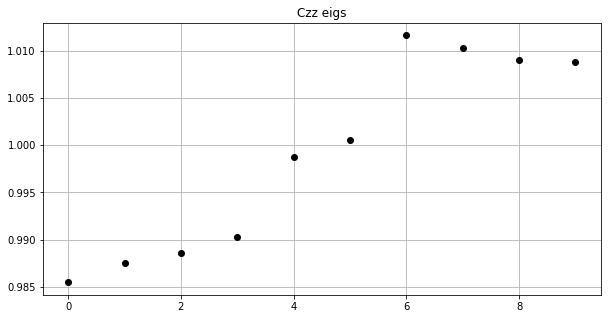

Epoch 4:
run time: 20.521340131759644 seconds


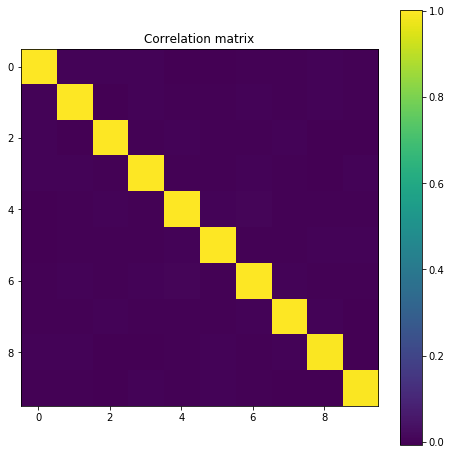

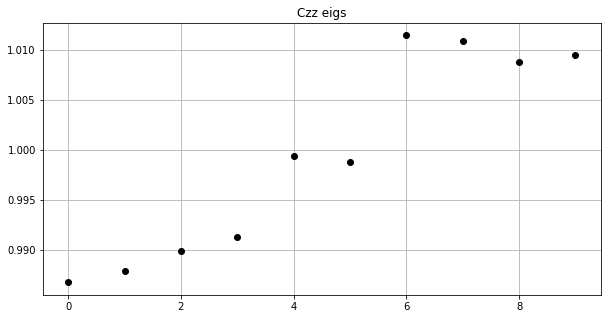

Epoch 5:
run time: 25.983604907989502 seconds


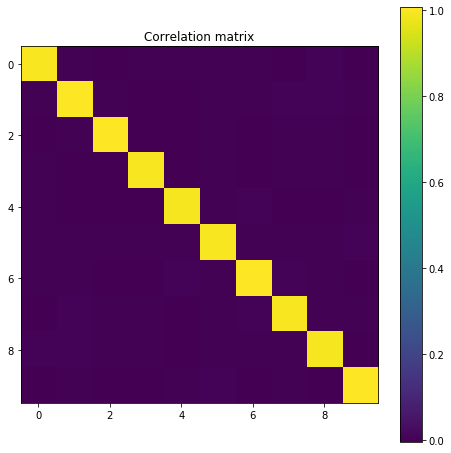

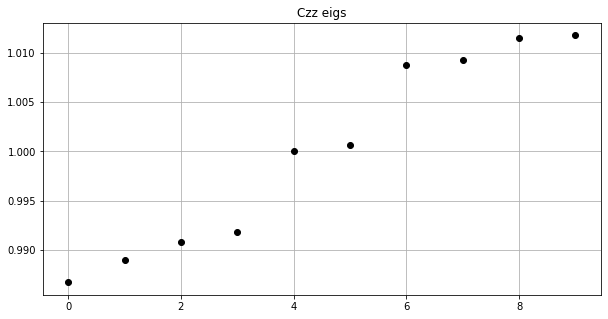

In [18]:
for logeta0 in logeta0_list:
    
    eta0 = 10**logeta0
    
    for logdecay in logdecay_list:
        
        decay = 10**logdecay
        
        for tau in tau_list:

            subspace_error_X = np.zeros((trials,domain_len))
            subspace_error_Y = np.zeros((trials,domain_len))
            Z_eigs = np.zeros((trials,domain_len,z_dim))
            runtime = np.zeros((trials,domain_len))
            
            print('eta0={}'.format(eta0),'decay={}'.format(decay),'tau={}'.format(tau))
            
            for trial in range(trials):

                print('Trial {}:'.format(trial+1))
                
                Z = np.zeros((z_dim,iters))
                
                Wx = np.random.randn(z_dim,x_dim)
                Wy = np.random.randn(z_dim,y_dim)
                
                P = np.eye(z_dim)
                
                start_time = time.time()
                domain_iter = 0
                
                for m in range(epochs):

                    print('Epoch {}:'.format(m+1))

                    idx = np.random.permutation(samples) # random permutation of the samples

                    for j in range(samples):

                        t = m*samples + j

                        eta_t = eta0/(1+decay*t)

                        i = idx[j]

                        # input

                        x = X[:,i]
                        y = Y[:,i]

                        # neural dynamics

                        a = Wx@x
                        b = Wy@y
                        z = inv(P.T@P+alpha*np.eye(z_dim))@(a+b); Z[:,t] = z
                        n = P@z

                        # synaptic updates

                        Wx = Wx + 2*eta_t*np.outer(z-a,x)
                        Wy = Wy + 2*eta_t*np.outer(z-b,y)
                        P = P + (eta_t/tau)*(np.outer(n,z) - P)

#                         if t in domain:
#                             Vx = Wx.T@inv(P.T@P+alpha*np.eye(z_dim));
#                             Vy = Wy.T@inv(P.T@P+alpha*np.eye(z_dim));
                            
#                             subspace_error_X[trial,domain_iter] = norm(Vx@inv(Vx.T@Vx)@Vx.T-Ux@inv(Ux.T@Ux)@Ux.T)
#                             runtime[trial,domain_iter] = time.time() - start_time
#                             domain_iter = domain_iter + 1

                    # output

#                     Vx = Wx.T@inv(P.T@P+alpha*np.eye(z_dim));
#                     Vy = Wy.T@inv(P.T@P+alpha*np.eye(z_dim));
                    
                    print('run time: %s seconds' % (time.time() - start_time))
#                     print('subspace error:', norm(Vx@inv(Vx.T@Vx)@Vx.T-Ux@inv(Ux.T@Ux)@Ux.T)**2/norm(Ux@Ux.T)**2)
                    
                    Czz = np.cov(Z[:,:t])
                    
                    s, v = np.linalg.eig(Czz)

                    fig = plt.figure(figsize=(8,8))

                    plt.imshow(Czz)
                    plt.title('Correlation matrix')
                    plt.colorbar()
                    plt.show()                                                
                    
                    fig = plt.figure(figsize=(10,5))

                    plt.plot(s, 'o', color='black')
                    plt.title('Czz eigs')
                    plt.grid()
                    plt.show()

            # specify path for saving data
            
#             cwd = os.getcwd() # current working directory  
            
#             path = f'{cwd}/error/synthetic/{z_dim}-dim/adaptive_bio-cca/logeta0={logeta0}/logdecay={logdecay}/tau={tau}' 

#             # create directory if path does not exist

#             if os.path.exists(path)==False:
#                 os.makedirs(path)

            # save data
            
#             np.save(f'{path}/error.npy', error)
#             np.save(f'{path}/runtime.npy', runtime)